Things included in this notebook:


In [5]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

import make_figures_great_again

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.decomposition import PCA
from sklearn import linear_model
from collections import Counter
import statsmodels.api as sm
import numpy as np
import scipy as sp
import os
import mpld3
import palettable

sig_level = 0.05

# File locations
faculty_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/faculty_cs_CURRENT.txt'
inst_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/inst_cs_CURRENT.txt'
figures_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/notebooks-productivity/figures/'
nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/profiles_DBLP_Nov16/'

In [4]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

## Controling for inflation

Publication rates increase for a variety of reasons throughout the course of our dataset. For example, the rising number of publication venues, higher levels of collaboration, and easier access to and improved visibility of research translates into more publications that are more easily found. We need to control for these factors the best we can, in order to spot pervasive patterns in publication trajectories.

In [8]:
pubs_per_year = {y:[] for y in xrange(1970,2012)}
count_MAP = False
smoothing = False
smoother = [0.2, 0.7, 0.1]

def smooth(x, times=1):
    for i in xrange(times):
        x = np.convolve(x, smoother)[1:-1]
    return x

for person in asst_faculty:
    start_year = person.first_asst_job_year
    career_length = 2012 - start_year
    if 'dblp_pubs' not in person:
        continue 
        
    pub_years_f = []
    pub_years_m = []
    pub_years_l = []
    
    for pub in person['dblp_pubs']:
        last_name = person.facultyName.split()[-1].lower()
        if pub['pub_type'] in ['inproceedings', 'article'] and pub['year'] is not None \
           and pub['year'] < 2012 and pub['year'] >= start_year:
            # First author.
            if pub['author_role'] == FAP:
                pub_years_f.append(pub['year'] - start_year)
            # Last author.
            elif pub['author_role'] == LAP:
                pub_years_l.append(pub['year'] - start_year)
            # Somewhere in the middle.
            else:
                pub_years_m.append(pub['year'] - start_year)

    pub_counter_f = Counter(pub_years_f)
    pub_counts_f = np.array([pub_counter_f[y] for y in xrange(career_length)])
    pub_counter_m = Counter(pub_years_m)
    pub_counts_m = np.array([pub_counter_m[y] for y in xrange(career_length)])
    pub_counter_l = Counter(pub_years_l)
    pub_counts_l = np.array([pub_counter_l[y] for y in xrange(career_length)])

    if count_MAP:
        pub_counts = pub_counts_f + pub_counts_m + pub_counts_l
    else:
        pub_counts = pub_counts_f + pub_counts_l
        
    if smoothing:
        pub_counts = smooth(pub_counts, 3)
        
    for y in xrange(career_length):
        pubs_per_year[start_year+y].append(pub_counts[y])

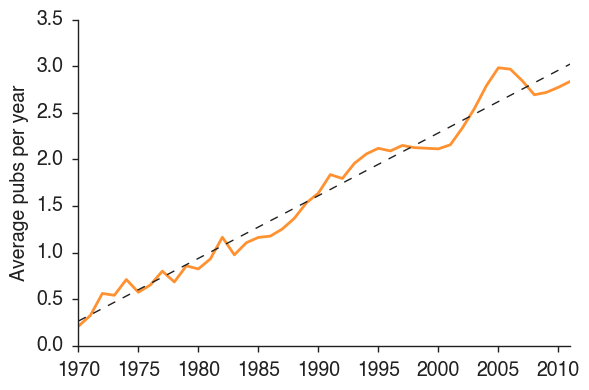

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

year_range = np.arange(1970,2012)
avg_pubs = [np.mean(pubs_per_year[y]) for y in year_range]
ax.plot(year_range, avg_pubs, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)

[slope,intercept] = np.polyfit(year_range,avg_pubs,1)
x = np.array([1970,2011])
ax.plot(x, slope*x + intercept, '--', color=ALMOST_BLACK)
ax.set_xlim(1970,2011)
ax.set_ylabel('Average pubs per year')

finalize(ax)
plt.savefig(figures_dir + 'inflation.pdf')
plt.show()

In [10]:
# Let's make a conversion function to simplify things
conv = lambda x: (1980*slope+intercept)/(x*slope+intercept)
2*conv(1997)

0.90062316344006998

So, each publication in year y counts for conv(y) publications in the final analysis. 